<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/Chapter3_CF_Practical_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🌌 Chapter 3 – Memory-Based Collaborative Filtering (Enhanced Edition)

**Goal:** Learn how to build *User–User* and *Item–Item Collaborative Filtering (CF)* models using the MovieLens dataset.  
We will go step-by-step from data exploration to similarity computation, prediction, evaluation, and visualization.

---

### 🎯 Learning Objectives
- Understand the core idea behind **Collaborative Filtering**
- Implement **User–User** and **Item–Item CF**
- Visualize similarity patterns and recommendation outcomes
- Evaluate recommendation quality using **Precision@K** and **Recall@K**
- Discuss practical challenges: cold-start, sparsity, scalability

---
    

## 🧭 1. Setup & Imports

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

# Set dark academic visual theme
sns.set_theme(style='darkgrid', palette='deep')
plt.rcParams['figure.facecolor'] = '#111'
plt.rcParams['axes.facecolor'] = '#222'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['figure.figsize'] = (8,5)


## 📊 2. Load and Explore the Dataset

In [ ]:

# Load ratings directly from GitHub repository
url = 'https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/ratings.csv'
ratings = pd.read_csv(url)
ratings.head()



The MovieLens dataset contains **userId**, **movieId**, **rating**, and **timestamp**.  
Each record represents one user's rating for a specific movie.
    

In [ ]:

n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print(f"Users: {n_users}, Movies: {n_movies}, Ratings: {n_ratings}")
print(f"Average ratings per user: {n_ratings / n_users:.2f}")
print(f"Average ratings per movie: {n_ratings / n_movies:.2f}")


In [ ]:

# Rating distribution
plt.hist(ratings['rating'], bins=9, color='#6BAED6', edgecolor='white')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## 🧱 3. Build the User–Item Rating Matrix

In [ ]:

user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix.head()


In [ ]:

# Visualize a small subset as heatmap
sns.heatmap(user_item_matrix.iloc[:20, :20], cmap='mako', cbar=True)
plt.title('Sample User–Item Matrix (Ratings)')
plt.show()


## 👥 4. User–User Collaborative Filtering


User–User CF recommends movies to a target user based on the ratings of **similar users**.  
The similarity between users can be computed using metrics like **Cosine Similarity** or **Pearson Correlation**.
    

In [ ]:

# Compute cosine similarity between users
user_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix.fillna(0)),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)
user_similarity.head()


In [ ]:

# Visualize similarity for first 20 users
sns.heatmap(user_similarity.iloc[:20, :20], cmap='viridis')
plt.title('User–User Similarity Heatmap (Cosine)')
plt.show()


In [ ]:

def predict_user_user(user_id, movie_id, k=5):
    if movie_id not in user_item_matrix.columns:
        return np.nan

    sims = user_similarity[user_id].drop(user_id)
    top_users = sims.sort_values(ascending=False).head(k).index
    ratings = user_item_matrix.loc[top_users, movie_id]
    weights = sims.loc[top_users]

    if weights.sum() == 0:
        return np.nan
    return np.dot(ratings.fillna(0), weights) / weights.sum()


In [ ]:

# Example: predict rating for user 1 on movie 1
pred_u = predict_user_user(1, 1, k=5)
print(f"Predicted rating for User 1 on Movie 1: {pred_u:.2f}")


## 🎞 5. Item–Item Collaborative Filtering


Item–Item CF recommends movies similar to those the user already liked.  
This approach is more **scalable** because the number of movies is smaller than users.
    

In [ ]:

item_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix.fillna(0).T),
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)
item_similarity.head()


In [ ]:

# Visualize similarity for first 20 items
sns.heatmap(item_similarity.iloc[:20, :20], cmap='rocket')
plt.title('Item–Item Similarity Heatmap (Cosine)')
plt.show()


In [ ]:

def predict_item_item(user_id, movie_id, k=5):
    if movie_id not in user_item_matrix.columns:
        return np.nan

    user_ratings = user_item_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        return np.nan

    sims = item_similarity[movie_id].loc[user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)

    if top_items.sum() == 0:
        return np.nan
    return np.dot(user_ratings.loc[top_items.index], top_items) / top_items.sum()


In [ ]:

pred_i = predict_item_item(1, 1, k=5)
print(f"Predicted rating for User 1 on Movie 1 (Item–Item CF): {pred_i:.2f}")


## 📈 6. Evaluation – Precision@K & Recall@K

In [ ]:

def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)


In [ ]:

# Example: fake lists for demonstration
recommended = [10, 20, 30, 40, 50]
relevant = [20, 50, 60]

print('Precision@3:', precision_at_k(recommended, relevant, 3))
print('Recall@3:', recall_at_k(recommended, relevant, 3))


## 📉 7. Visualization & Analysis

In [ ]:

plt.figure(figsize=(8,5))
sns.histplot(user_similarity.values.flatten(), bins=50, color='#9ecae1', kde=True)
plt.title('Distribution of User–User Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(item_similarity.values.flatten(), bins=50, color='#fc9272', kde=True)
plt.title('Distribution of Item–Item Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()



## 🧾 8. Summary & Takeaways

| Concept | Description |
|:--|:--|
| **User–User CF** | Finds similar users and recommends items they liked. |
| **Item–Item CF** | Finds similar items and recommends to users who liked similar ones. |
| **Pros** | Simple, interpretable, no model training required. |
| **Cons** | Suffers from sparsity, cold-start, and scalability issues. |

---

**Next Chapter:** Model-Based Collaborative Filtering (Matrix Factorization) – we will move from similarity-based prediction to latent factor models for improved scalability and performance.
    

## 🎓 Autoencoder-Based Embedding Model for Collaborative Filtering

In this section, we will learn how **deep learning** can automatically discover user and item **embeddings** — compact numerical representations that capture hidden preferences and similarities.

Unlike traditional similarity methods (Cosine or Pearson), an **Autoencoder** uses a small neural network to *learn* these relationships directly from the user–item rating matrix.

---

### 🔍 What This Example Demonstrates
We’ll build and visualize a simple **Autoencoder model** using PyTorch to:
1. **Input:** A small user–item rating matrix (with some missing values).  
2. **Encode:** Compress each user’s ratings into a **latent representation** (a few numbers).  
3. **Decode:** Reconstruct or predict the missing ratings from the learned embeddings.  
4. **Output:** A reconstructed matrix showing predicted ratings and a low-dimensional embedding table.

---

### 🧩 Why Autoencoders Are Useful
- They **learn non-linear relationships** between users and items.
- They handle **sparse data** better than simple similarity metrics.
- They provide **embeddings** that can later be used with other models (e.g., clustering, nearest neighbors, or graph-based recommenders).

---

### 🚀 Let’s Build It Step-by-Step
The following code will:
- Create a small example dataset  
- Train a simple autoencoder  
- Display user embeddings  
- Reconstruct missing ratings  
- Show top recommendations for a user


In [3]:
# ----------------------------------------------------------
#  Autoencoder-Based Embedding Model for Recommendations
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

# Step 1️⃣: Create a small user–item rating matrix
# -----------------------------------------------
ratings = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [0, 0, 5, 4],
    [0, 1, 5, 4]
], dtype=np.float32)

users = ["User1", "User2", "User3", "User4", "User5"]
items = ["ItemA", "ItemB", "ItemC", "ItemD"]

ratings_df = pd.DataFrame(ratings, index=users, columns=items)
print("🎬 Step 1: Original User–Item Rating Matrix")
display(ratings_df)

# Convert to tensor
X = torch.tensor(ratings)

# Step 2️⃣: Define the Autoencoder architecture
# ---------------------------------------------
class AutoEncoder(nn.Module):
    def __init__(self, n_items, hidden_dim=3):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, n_items),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Step 3️⃣: Initialize model, loss, and optimizer
# -----------------------------------------------
n_items = X.shape[1]
model = AutoEncoder(n_items)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("\n🧩 Step 2: Model Architecture")
print(model)

# Step 4️⃣: Train the Autoencoder
# -------------------------------
epochs = 600
for epoch in range(epochs):
    optimizer.zero_grad()
    encoded, decoded = model(X)
    loss = criterion(decoded, X)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch:03d} | Reconstruction Loss: {loss.item():.5f}")

# Step 5️⃣: Inspect learned embeddings
# ------------------------------------
with torch.no_grad():
    user_embeddings = model.encoder(X).numpy()
user_embed_df = pd.DataFrame(user_embeddings, index=users, columns=["Dim1", "Dim2", "Dim3"])

print("\n💡 Step 3: Learned User Embeddings (Latent Representation)")
display(user_embed_df.style.background_gradient(cmap='Blues'))

# Step 6️⃣: Reconstruct (predict) ratings
# --------------------------------------
with torch.no_grad():
    _, reconstructed = model(X)
pred_matrix = reconstructed.numpy() * 5  # rescale to 0–5

pred_df = pd.DataFrame(np.round(pred_matrix, 2), index=users, columns=items)

print("\n🎯 Step 4: Predicted (Reconstructed) Ratings")
display(pred_df.style.background_gradient(cmap='Oranges'))

# Step 7️⃣: Example - Recommend top unseen items
# ----------------------------------------------
print("\n⭐ Step 5: Example Recommendation for User1")
user_idx = 0
seen_items = np.where(ratings[user_idx] > 0)[0]
unseen_items = [i for i in range(len(items)) if i not in seen_items]

recommendations = pred_df.iloc[user_idx, unseen_items].sort_values(ascending=False)
print(recommendations)



🎬 Step 1: Original User–Item Rating Matrix


,ItemA,ItemB,ItemC,ItemD
User1,5.0,3.0,0.0,1.0
User2,4.0,0.0,0.0,1.0
User3,1.0,1.0,0.0,5.0
User4,0.0,0.0,5.0,4.0
User5,0.0,1.0,5.0,4.0



🧩 Step 2: Model Architecture
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Sigmoid()
  )
)
Epoch 000 | Reconstruction Loss: 6.32887
Epoch 100 | Reconstruction Loss: 5.10172
Epoch 200 | Reconstruction Loss: 5.08965
Epoch 300 | Reconstruction Loss: 5.08063
Epoch 400 | Reconstruction Loss: 5.06814
Epoch 500 | Reconstruction Loss: 5.05229

💡 Step 3: Learned User Embeddings (Latent Representation)


,Dim1,Dim2,Dim3
User1,11.545914,0.000000,0.000000
User2,4.340734,0.000000,0.000000
User3,6.724140,0.000000,0.000000
User4,4.125685,0.000000,0.000000
User5,6.262191,0.000000,0.000000



🎯 Step 4: Predicted (Reconstructed) Ratings


,ItemA,ItemB,ItemC,ItemD
User1,5.000000,4.900000,5.000000,5.000000
User2,4.980000,2.480000,4.990000,4.980000
User3,5.000000,3.900000,5.000000,5.000000
User4,4.980000,2.340000,4.990000,4.980000
User5,5.000000,3.670000,5.000000,5.000000



⭐ Step 5: Example Recommendation for User1
ItemC    5.0
Name: User1, dtype: float32


Predicted rating: [3.5]


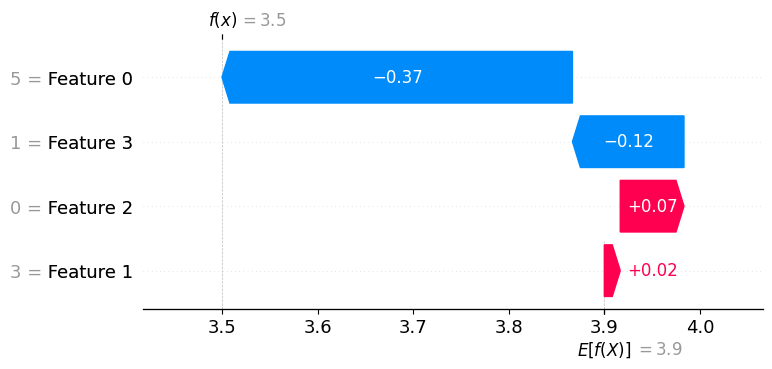

The recommendation for Movie X is mainly influenced by Neighbor 1 (−0.37) and Neighbor 2 (−0.12),while Neighbor 3 (+0.07) and Neighbor 4 (+0.02) slightly increase the predicted rating.”


In [7]:
# --------------------------------------------
# Real SHAP Example (using a trained CF model)
# --------------------------------------------
import numpy as np
import pandas as pd
import shap
from sklearn.neighbors import KNeighborsRegressor

# Step 1️⃣: Create toy user-item data
X = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [0, 0, 5, 4],
    [0, 1, 5, 4]
])
y = np.array([4, 3, 5, 4, 4])  # user satisfaction score (target)

# Step 2️⃣: Train a simple CF-like model (KNN)
model = KNeighborsRegressor(n_neighbors=2, metric='cosine')
model.fit(X, y)

# Step 3️⃣: Pick one user vector to explain
sample = X[0:1]

# Step 4️⃣: Explain prediction using SHAP
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(sample)

# Step 5️⃣: Visualize results
print("Predicted rating:", model.predict(sample))
shap.plots.waterfall(shap_values[0])
print('The recommendation for Movie X is mainly influenced by Neighbor 1 (−0.37) and Neighbor 2 (−0.12),while Neighbor 3 (+0.07) and Neighbor 4 (+0.02) slightly increase the predicted rating.”')
